In [46]:
import numpy as np
import pandas as pd
import json
import pickle
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
from datasets import load_from_disk
from transformers import (
    SegformerFeatureExtractor,
    logging,
    SegformerForSemanticSegmentation,
)
import torch
from torch import nn

pd.options.mode.copy_on_write = True

image_size = (512, 512)


In [2]:
train_df = pd.read_csv("train_df.csv", index_col=0)
ds_name = "Dataset_BUSI_with_GT"
train_df[train_df["dataset"] == ds_name]


,dataset,image,mask,tumor,dataset_tumor
725,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,benign,Dataset_BUSI_with_GT_benign
726,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,benign,Dataset_BUSI_with_GT_benign
727,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,benign,Dataset_BUSI_with_GT_benign
728,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,benign,Dataset_BUSI_with_GT_benign
729,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,benign,Dataset_BUSI_with_GT_benign
...,...,...,...,...,...
1500,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,normal,Dataset_BUSI_with_GT_normal
1501,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,normal,Dataset_BUSI_with_GT_normal
1502,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,normal,Dataset_BUSI_with_GT_normal
1503,Dataset_BUSI_with_GT,/home/florin/data/BUS Project Home/Datasets/Da...,['/home/florin/data/BUS Project Home/Datasets/...,normal,Dataset_BUSI_with_GT_normal


In [3]:
ds_hf = load_from_disk("bus_4in1_datasets_single_class_512")
ds_hf[0]


{'dataset': 0,
 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'tumor': 0,
 'dataset_tumor': 0,
 'index': 0,
 'original_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>}

In [4]:
id2label = {0: "unlabeled", 1: "lesion"}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

feature_extractor = SegformerFeatureExtractor(do_normalize=True).from_pretrained(
    "nvidia/mit-b3"
)

inputs_template = feature_extractor(
    images=ds_hf[725]["pixel_values"], return_tensors="pt"
)

logging.set_verbosity(50)
model_baseline = SegformerForSemanticSegmentation.from_pretrained(
    "model_baseline_mit-b3/models/fold-0000000001",
    id2label=id2label,
    label2id=label2id,
    num_labels=num_labels,
)
model_baseline.to("cuda:0")
logging.set_verbosity(40)


In [5]:
def predict_one(model, image):
    """
    inputs:
    - model
    - PIL image

    output:
    - PIL format prediction
    """
    with torch.no_grad():
        image_array = np.moveaxis(np.array(image, dtype=np.uint8), -1, 0).copy()
        inputs = feature_extractor(images=image_array, return_tensors="pt")
        inputs.to("cuda:0")
        outputs = model(**inputs)
        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image_array.shape[1:],
            mode="bilinear",
            align_corners=False,
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0]
        pred_seg_cpu = pred_seg.detach().cpu()
        pred_np = np.array(pred_seg_cpu, dtype=np.int8)
        pred_pil = Image.fromarray(pred_np, mode="L")
        return ImageOps.colorize(
            pred_pil,
            black=[0, 0, 0],
            white=[255, 255, 0],
            blackpoint=0,
            whitepoint=1,
        )


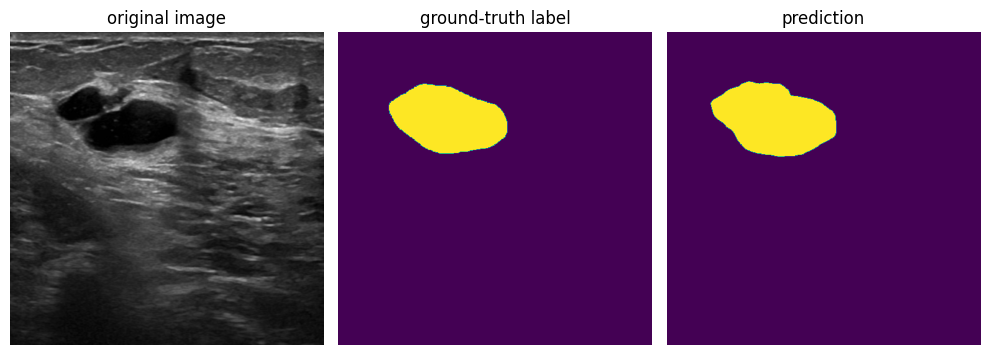

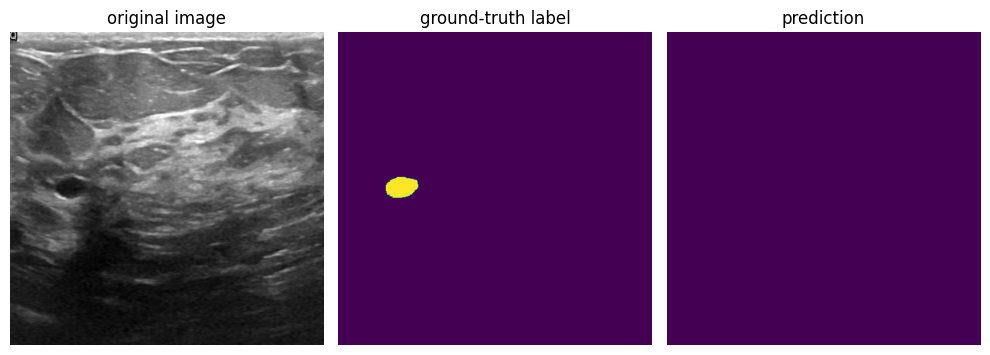

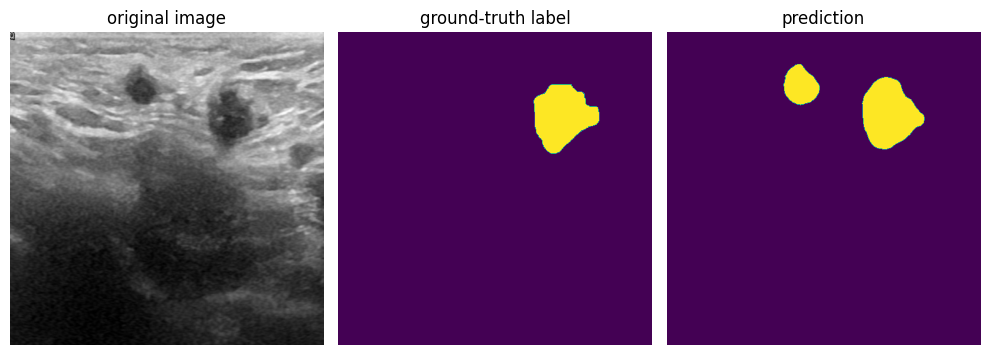

In [6]:
ds_start = 725
for j in [726, 822, 1194]:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    image = ds_hf[j]["original_image"]
    prediction = predict_one(model_baseline, image).convert("L")
    ax[0].imshow(image)
    ax[0].set_axis_off()
    ax[0].set_title("original image")
    ax[1].imshow(ds_hf[j]["label"])
    ax[1].set_axis_off()
    ax[1].set_title("ground-truth label")
    ax[2].imshow(prediction)
    ax[2].set_axis_off()
    ax[2].set_title("prediction")
    fig_name = "predict_" + str(j) + ".png"
    fig.tight_layout()
    fig.savefig(fig_name, bbox_inches="tight")
    fig.show()


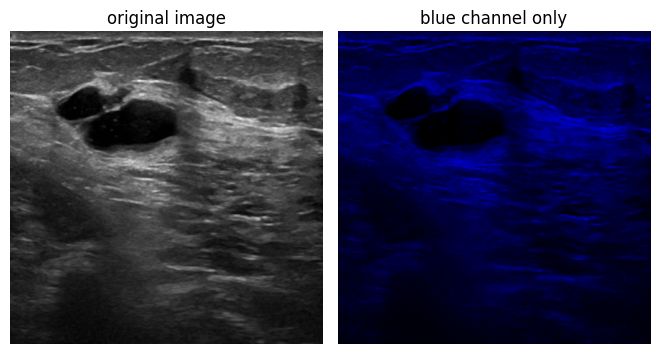

In [7]:
j = 726
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.7, 4))
original = ds_hf[j]["original_image"]
blue_shift = ds_hf[j]["pixel_values"]
prediction = predict_one(model_baseline, image).convert("L")
ax[0].imshow(original)
ax[0].set_axis_off()
ax[0].set_title("original image")
ax[1].imshow(blue_shift)
ax[1].set_axis_off()
ax[1].set_title("blue channel only")
fig_name = "blue_" + str(j) + ".png"
fig.tight_layout()
fig.savefig(fig_name, bbox_inches="tight")
fig.show()


In [8]:
with open("model_baseline_mit-b3/guide_clicks.json", "r") as gcfile:
    guide_clicks = json.load(gcfile)
    guide_clicks = {int(k): v for k, v in guide_clicks.items()}


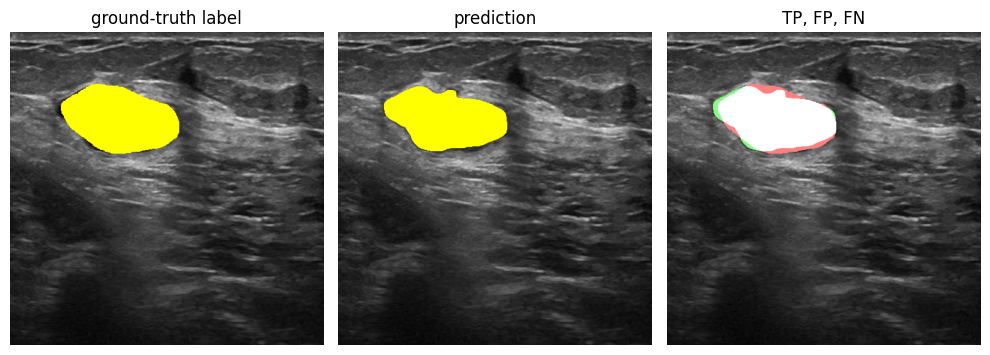

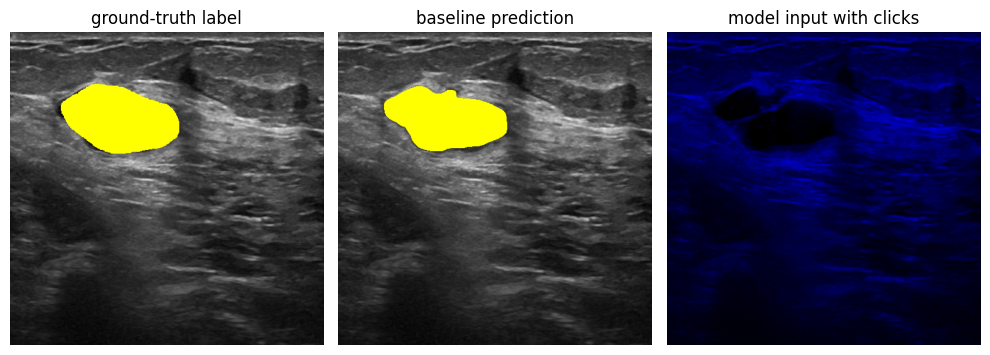

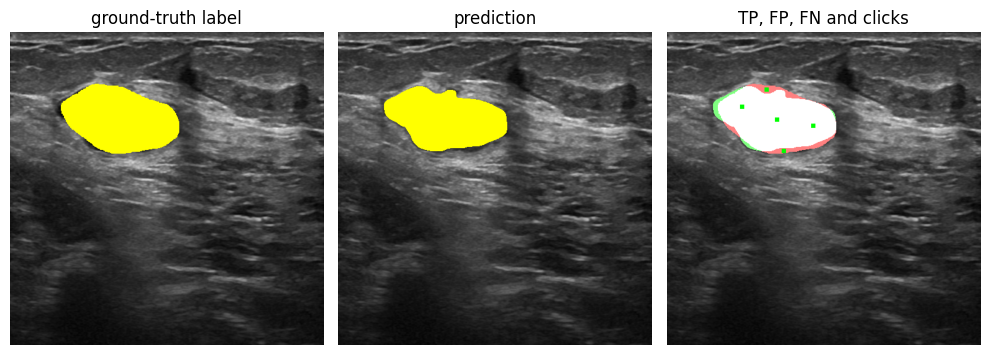

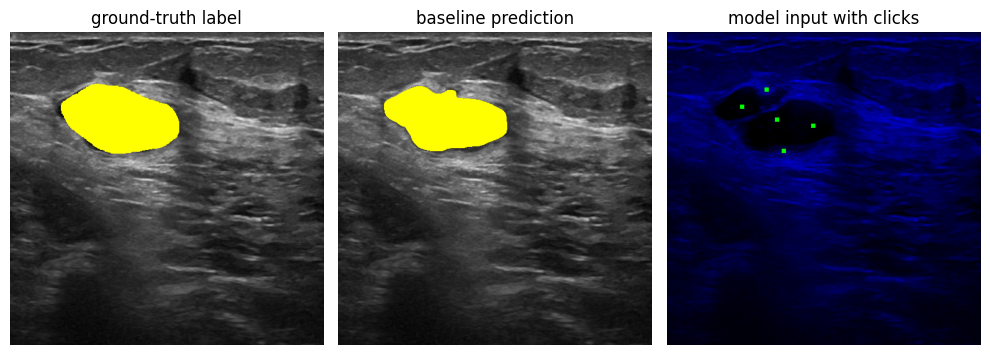

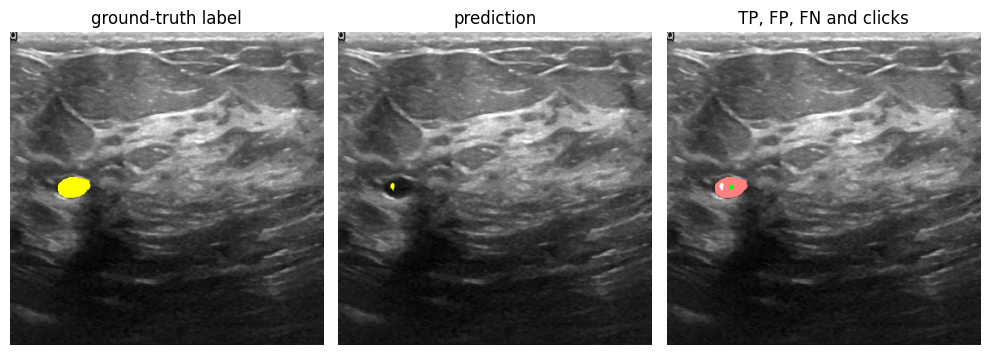

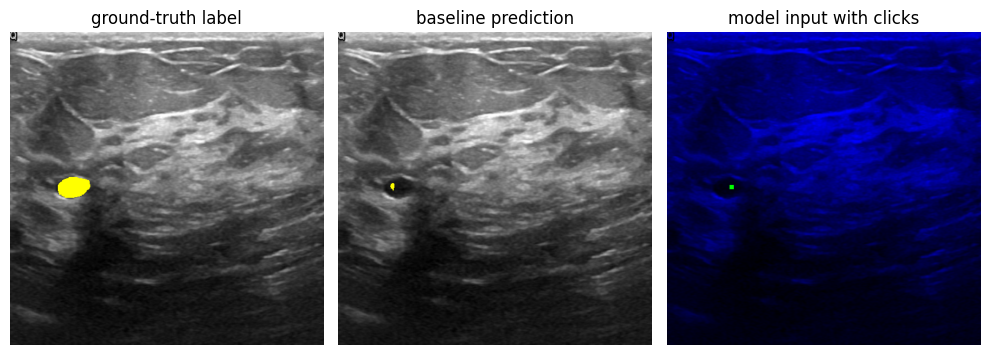

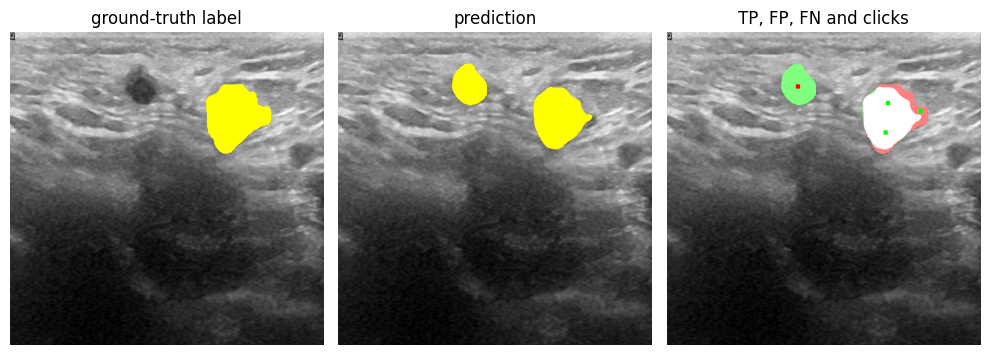

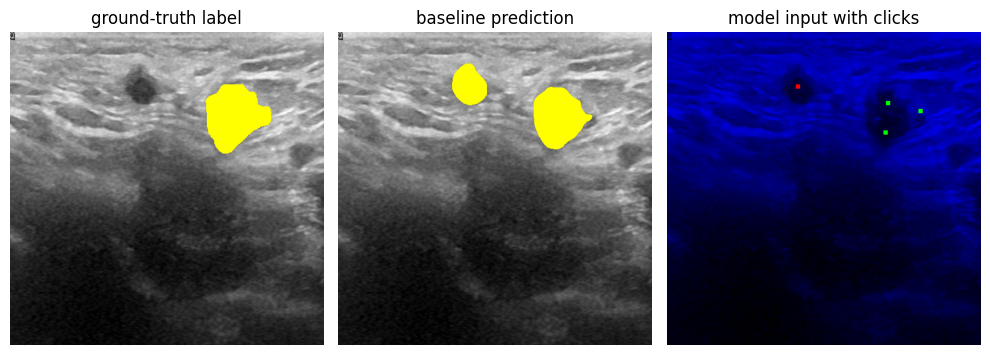

In [9]:
s_color = {
    "true_positives": [255, 255, 255],
    "false_positives": [128, 255, 128],
    "false_negatives": [255, 128, 128],
}

segment_files = "model_baseline_mit-b3/segment_files/"
segment_stats = pd.read_csv("model_baseline_mit-b3/segment_stats.csv", index_col=0)
image_perf_df = pd.read_csv("model_baseline_mit-b3/image_perf_df.csv", index_col=0)

click_size = 3


def draw_areas(i, show_clicks=True):
    original_image = ds_hf[i]["original_image"]
    pixel_values = ds_hf[i]["pixel_values"]

    image_stats = segment_stats[segment_stats["image_index"] == i]
    clicks = guide_clicks[i]

    label_arr = np.array(ds_hf[i]["label"], dtype=np.uint8) * 255
    label_img = ImageOps.colorize(
        Image.fromarray(label_arr, mode="L"),
        black=[0, 0, 0],
        white=[255, 255, 0],
        blackpoint=0,
        whitepoint=255,
    )
    img_label_merged = Image.composite(
        label_img, original_image, Image.fromarray(label_arr, mode="L")
    )

    prediction = original_image
    for st in s_color.keys():
        if st == "false_negatives":
            continue
        st_stats = image_stats[image_stats["segment_type"] == st]
        for s in st_stats.iterrows():
            with open(
                segment_files
                + "/"
                + str(i)
                + "/"
                + st
                + "/"
                + str(s[1]["segment_index"])
                + ".pkl",
                "rb",
            ) as s_file:
                s_arr = pickle.load(s_file)
                s_arr = s_arr * 255
                s_img = ImageOps.colorize(
                    Image.fromarray(s_arr, mode="L"),
                    black=[0, 0, 0],
                    white=[255, 255, 0],
                    blackpoint=0,
                    whitepoint=255,
                )
                prediction = Image.composite(
                    s_img, prediction, Image.fromarray(s_arr, mode="L")
                )

    s_merged = original_image
    for st in s_color.keys():
        st_stats = image_stats[image_stats["segment_type"] == st]
        for s in st_stats.iterrows():
            with open(
                segment_files
                + "/"
                + str(i)
                + "/"
                + st
                + "/"
                + str(s[1]["segment_index"])
                + ".pkl",
                "rb",
            ) as s_file:
                s_arr = pickle.load(s_file)
                s_arr = s_arr * 255
                s_img = ImageOps.colorize(
                    Image.fromarray(s_arr, mode="L"),
                    black=[0, 0, 0],
                    white=s_color[st],
                    blackpoint=0,
                    whitepoint=255,
                )
                s_merged = Image.composite(
                    s_img, s_merged, Image.fromarray(s_arr, mode="L")
                )

    if show_clicks:
        for c in clicks["clicks_positive_tp"]:
            # Pillow and Numpy disagree on the meaning of X and Y
            # we use the Numpy convention
            # so for Pillow we swap X and Y
            ImageDraw.Draw(s_merged).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(0, 255, 0),
                fill=(0, 255, 0),
                width=1,
            )
            ImageDraw.Draw(pixel_values).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(0, 255, 0),
                fill=(0, 255, 0),
                width=1,
            )

        for c in clicks["clicks_positive"]:
            # Pillow and Numpy disagree on the meaning of X and Y
            # we use the Numpy convention
            # so for Pillow we swap X and Y
            ImageDraw.Draw(s_merged).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(0, 255, 0),
                fill=(0, 255, 0),
                width=1,
            )
            ImageDraw.Draw(pixel_values).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(0, 255, 0),
                fill=(0, 255, 0),
                width=1,
            )

        for c in clicks["clicks_negative"]:
            # Pillow and Numpy disagree on the meaning of X and Y
            # we use the Numpy convention
            # so for Pillow we swap X and Y
            ImageDraw.Draw(s_merged).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(255, 0, 0),
                fill=(255, 0, 0),
                width=1,
            )
            ImageDraw.Draw(pixel_values).rectangle(
                xy=[
                    (c[1] - click_size, c[0] - click_size),
                    (c[1] + click_size, c[0] + click_size),
                ],
                outline=(255, 0, 0),
                fill=(255, 0, 0),
                width=1,
            )

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    ax[0].imshow(img_label_merged)
    ax[0].set_axis_off()
    ax[0].set_title("ground-truth label")
    ax[1].imshow(prediction)
    ax[1].set_axis_off()
    ax[1].set_title("prediction")
    ax[2].imshow(s_merged)
    ax[2].set_axis_off()
    ax_title = "TP, FP, FN"
    if show_clicks:
        ax_title += " and clicks"
    ax[2].set_title(ax_title)
    if show_clicks:
        click_indicator = "_with_clicks"
    else:
        click_indicator = "_without_clicks"
    fig_name = "click_areas_" + str(i) + click_indicator + ".png"
    fig.tight_layout()
    fig.savefig(fig_name, bbox_inches="tight")
    fig.show()

    fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
    ax2[0].imshow(img_label_merged)
    ax2[0].set_axis_off()
    ax2[0].set_title("ground-truth label")
    ax2[1].imshow(prediction)
    ax2[1].set_axis_off()
    ax2[1].set_title("baseline prediction")
    ax2[2].imshow(pixel_values)
    ax2[2].set_axis_off()
    ax2[2].set_title("model input with clicks")
    fig2_name = "model_input_" + str(i) + click_indicator + ".png"
    fig2.tight_layout()
    fig2.savefig(fig2_name, bbox_inches="tight")
    fig2.show()


draw_areas(726, show_clicks=False)
for i in [726, 822, 1194]:
    draw_areas(i)


  0%|          | 0/512 [00:00<?, ?it/s]

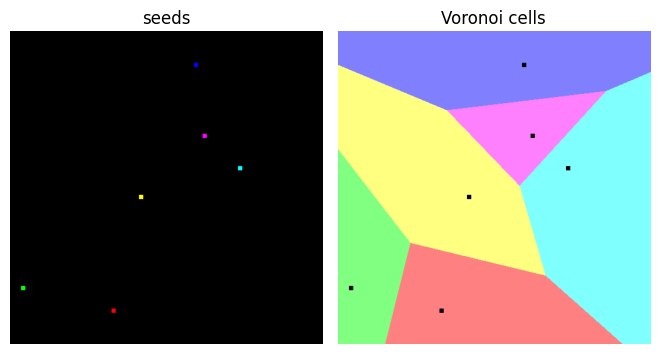

In [53]:
def nearest_click(x, y, vt_clicks):
    dist_min = image_size[0] * 2
    index_min = 0
    for i in range(vt_clicks.shape[0]):
        dist = np.sqrt(
            np.power(vt_clicks[i, 0] - x, 2) + np.power(vt_clicks[i, 1] - y, 2)
        )
        if dist < dist_min:
            dist_min = dist
            index_min = i
    return index_min


click_radius = 3
vt_colors_sat = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [255, 0, 255],
    [0, 255, 255],
]
vt_colors_unsat = [[x if x == 255 else 128 for x in c] for c in vt_colors_sat]
np.random.seed(seed=6)
vt_clicks = (np.random.rand(len(vt_colors_sat), 2) * image_size[0]).astype(np.int16)


def show_tiling(
    vt_clicks,
    vt_colors_sat,
    vt_colors_unsat,
    click_radius,
    title_left,
    title_right,
    file_name,
):
    vt_click_array = np.zeros(image_size + (3,), dtype=np.int8)
    vt_tile_array = np.zeros(image_size + (3,), dtype=np.int8)
    for x in tqdm(range(image_size[0])):
        for y in range(image_size[0]):
            i = nearest_click(x, y, vt_clicks)
            vt_tile_array[x, y, :] = vt_colors_unsat[i]

    for i in range(len(vt_colors_sat)):
        x = vt_clicks[i, 0]
        y = vt_clicks[i, 1]
        for m in range(x - click_radius, x + click_radius + 1):
            if m < 0 or m > image_size[0]:
                continue
            for n in range(y - click_radius, y + click_radius + 1):
                if n < 0 or n > image_size[0]:
                    continue
                vt_click_array[m, n, :] = vt_colors_sat[i]
                vt_tile_array[m, n, :] = [0, 0, 0]

    vt_click_frame = Image.fromarray(vt_click_array, mode="RGB")
    vt_tile_frame = Image.fromarray(vt_tile_array, mode="RGB")
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.7, 4))
    ax[0].imshow(vt_click_frame)
    ax[0].set_axis_off()
    ax[0].set_title(title_left)
    ax[1].imshow(vt_tile_frame)
    ax[1].set_axis_off()
    ax[1].set_title(title_right)
    fig.tight_layout()
    fig.savefig(file_name, bbox_inches="tight")
    plt.show()


show_tiling(
    vt_clicks,
    vt_colors_sat,
    vt_colors_unsat,
    click_radius,
    "seeds",
    "Voronoi cells",
    "voronoi_example.png",
)


  0%|          | 0/512 [00:00<?, ?it/s]

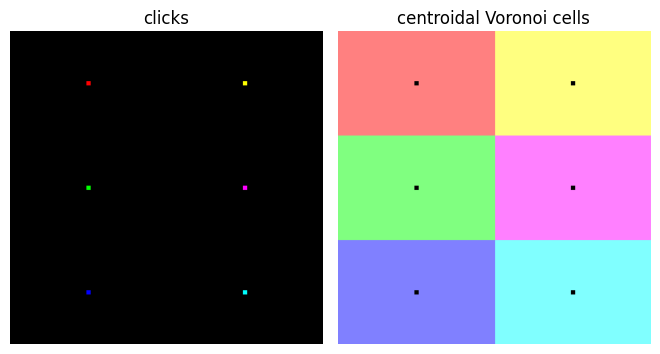

In [59]:
square_centroids = [
    (85, 128),
    (256, 128),
    (427, 128),
    (85, 384),
    (256, 384),
    (427, 384),
]
show_tiling(
    np.array(square_centroids, dtype=np.int16),
    vt_colors_sat,
    vt_colors_unsat,
    click_radius,
    "clicks",
    "centroidal Voronoi cells",
    "voronoi_example_centroidal.png",
)


In [63]:
from uniform_clicks import test_gamma

tg_baseline_dir = "article_energy_dir"
tg_frame_arr = np.full(image_size, 1, dtype=np.uint8)
tg_sp_schedule = {"tmax": 2000.0, "tmin": 0.1, "steps": 500, "updates": 0}
tg_n_points = 6
tg_args = (tg_baseline_dir, tg_frame_arr, tg_sp_schedule, tg_n_points)
if not os.path.exists(tg_baseline_dir):
    best_points, best_energy = test_gamma(tg_args)
    with open("centroid_best_points.pkl", "wb") as bpf:
        pickle.dump(best_points, bpf)

with open("centroid_best_points.pkl", "rb") as bpf:
    best_points = pickle.load(bpf)
best_points


[(107, 125), (388, 414), (414, 206), (213, 319), (82, 415), (340, 85)]

  0%|          | 0/512 [00:00<?, ?it/s]

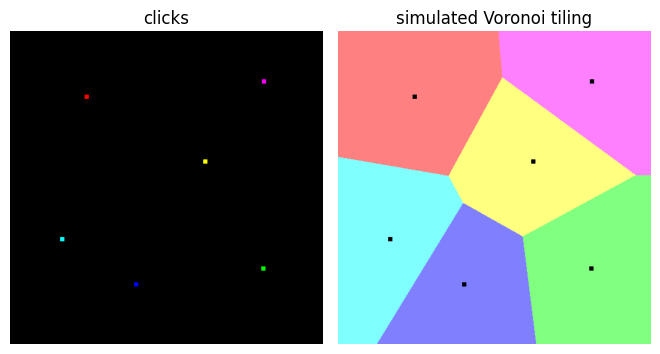

In [64]:
show_tiling(
    np.array(best_points, dtype=np.int16),
    vt_colors_sat,
    vt_colors_unsat,
    click_radius,
    "clicks",
    "simulated Voronoi tiling",
    "voronoi_example_simulated.png",
)


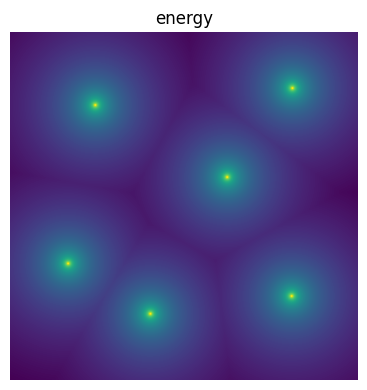

In [65]:
with open(tg_baseline_dir + "/energy/1/true_positives/1.pkl", "rb") as sf:
    _ = pickle.load(sf)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ax.set_axis_off()
ax.set_title("energy")
ax.imshow(np.log10(_))
fig.tight_layout()
fig.savefig("voronoi_energy.png", bbox_inches="tight")
fig.show()


In [88]:
s_frame = Image.new(mode="L", size=image_size, color=0)
s_draw = ImageDraw.Draw(s_frame)
s_draw.ellipse([(50, 50), (462, 462)], fill=255, outline=255)
s_draw.ellipse([(50, 110), (462, 522)], fill=0, outline=0)
s_frame_arr = np.array(s_frame)
s_frame_arr = (s_frame_arr / s_frame_arr.max()).astype(np.uint8)

s_baseline_dir = "article_sickle_dir"
s_sp_schedule = {"tmax": 2000.0, "tmin": 0.1, "steps": 500, "updates": 0}
s_n_points = 3
s_args = (s_baseline_dir, s_frame_arr, s_sp_schedule, s_n_points)
if not os.path.exists(s_baseline_dir):
    best_points_s, best_energy_s = test_gamma(s_args)
    with open("centroid_sickle_best_points.pkl", "wb") as bpf:
        pickle.dump(best_points_s, bpf)

with open("centroid_sickle_best_points.pkl", "rb") as bpf:
    best_points_s = pickle.load(bpf)
best_points_s


[(113, 147), (81, 268), (127, 385)]

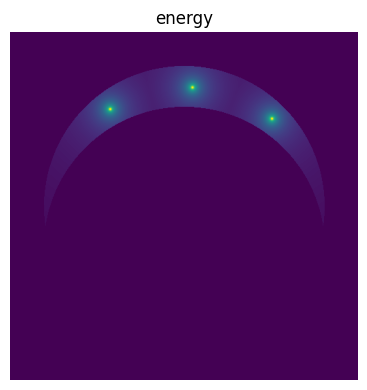

In [91]:
with open(s_baseline_dir + "/energy/1/true_positives/1.pkl", "rb") as sf:
    _ = pickle.load(sf)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ax.set_axis_off()
ax.set_title("energy")
ax.imshow(np.log10(_ + 0.05))
fig.tight_layout()
fig.savefig("voronoi_energy_sickle.png", bbox_inches="tight")
fig.show()


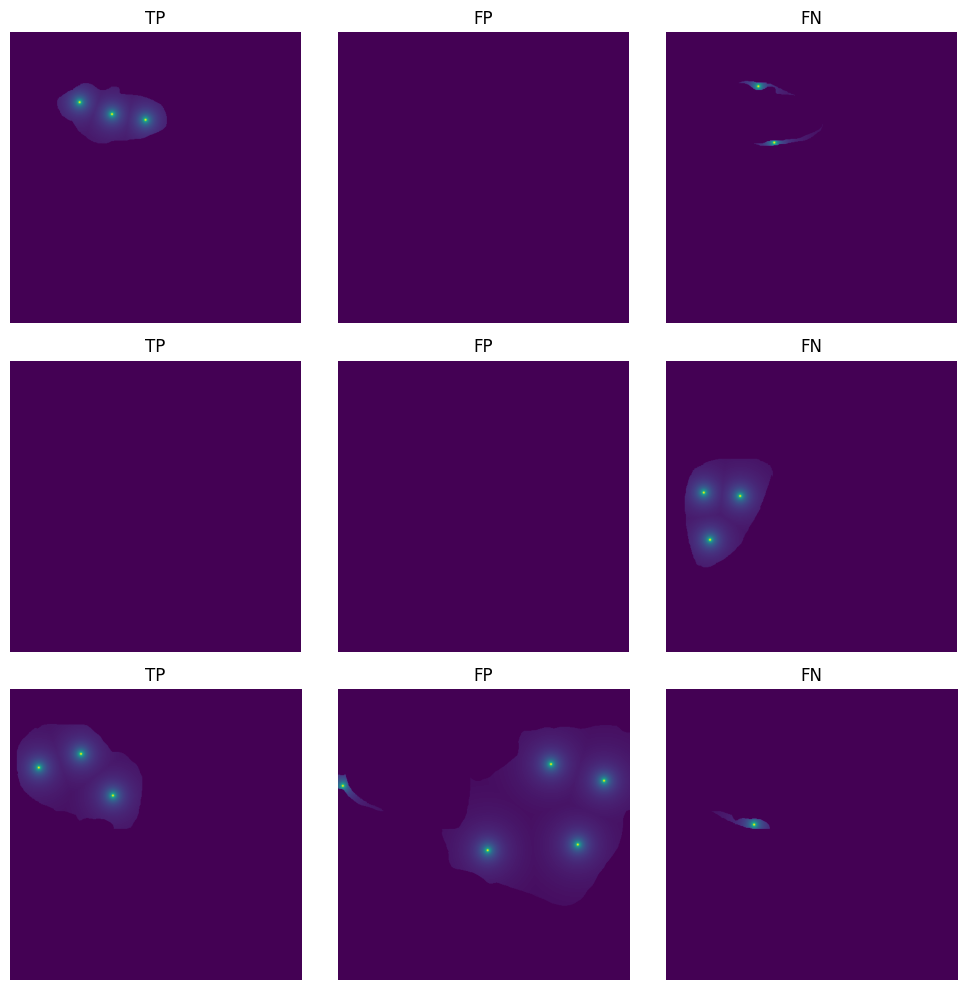

In [121]:
baseline_dir = "model_baseline_mit-b3"
image_list = [726, 750, 771]
fig, ax = plt.subplots(nrows=len(image_list), ncols=3, figsize=(10, 10))
for i in image_list:
    i_index = image_list.index(i)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/true_positives"
    tp_arr = np.zeros(image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                tp_arr += pickle.load(arr_file)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/false_positives"
    fp_arr = np.zeros(image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                fp_arr += pickle.load(arr_file)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/false_negatives"
    fn_arr = np.zeros(image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                fn_arr += pickle.load(arr_file)
    ax[i_index, 0].set_title("TP")
    ax[i_index, 1].set_title("FP")
    ax[i_index, 2].set_title("FN")
    ax[i_index, 0].set_axis_off()
    ax[i_index, 1].set_axis_off()
    ax[i_index, 2].set_axis_off()
    ax[i_index, 0].imshow(np.log10(tp_arr + 0.1))
    ax[i_index, 1].imshow(np.log10(fp_arr + 0.1))
    ax[i_index, 2].imshow(np.log10(fn_arr + 0.1))
fig.tight_layout()
fig.savefig("segments_clicks.png", bbox_inches="tight")
plt.show()
